<a href="https://colab.research.google.com/github/Vaycold/statistics_seminar/blob/main/Loaded_data4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer    
from google.colab import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '1c0e1716b23829d4381dcbced37ba49b'

!rm *.*
!kaggle competitions download -c sentiment-analysis-of-covid-19-related-tweets

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('validation.csv')

for module in ['stopwords', 'punkt', 'wordnet'] :
    nltk.download(module)

rm: cannot remove '*.*': No such file or directory
  0% 0.00/254k [00:00<?, ?B/s]
100% 254k/254k [00:00<00:00, 35.2MB/s]
  0% 0.00/518k [00:00<?, ?B/s]
100% 518k/518k [00:00<00:00, 73.2MB/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def labelsplit(labels) :
    
    label = labels.replace(' ',',').split(',')
    for idx, lab in enumerate(label) :
        label[idx] = int(lab)
    return label

In [ ]:
train_df['label']  = train_df['Labels'].apply(lambda x :  labelsplit(x))

In [ ]:
onehot = np.zeros((5000,11))
for i in range(5000) : # 0~5000 row
    for j in train_df.label[i] : # j = value   
        onehot[i,j]  = 1
cols_target = ['0','1','2','3','4','5','6','7','8','9','10']
onehot = pd.DataFrame(onehot, columns=cols_target)

In [ ]:
train_df = pd.concat(
    [train_df, onehot], axis=1
).drop(['ID','Labels', 'label'],axis=1)

## EDA

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 30
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 16.9214
 tweet 의 길이의 중간값 : 17.0




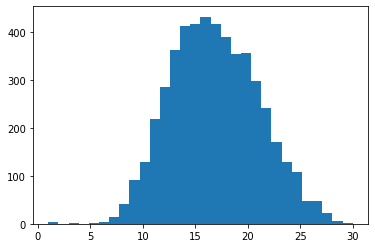

In [ ]:
# 단어의 갯수

word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=30)
plt.show()

## 텍스트 클렌징

In [ ]:
stop = stopwords.words('english')
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
def  clean_text(df, text_field='Tweet', new_text_field_name='clean_tweet'):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.lower())
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('corona','covid'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('coronavirus','virus'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_lemmatizer(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join(x))
    return df

In [ ]:
def clean_df(df) :
    DF = clean_text(df, 'Tweet', 'clean_tweet')
    try :
        DF = DF[['clean_tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]
        DF.columns = ['Tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    except :
        DF = DF[['ID','clean_tweet']]
        DF.columns = ['ID','Tweet']
    
    return DF
    
def one(x) :
    if x > 2 :
        return 1
    else :
        return 0

In [ ]:
train_df = clean_df(train_df)
test_df = clean_df(test_df)

In [ ]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
test_df.head(2)

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...


In [ ]:
# 단어수 
print(len(set([word for words in train_tweet for word in words.split()])))

8517


 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 21
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1706
 tweet 의 길이의 중간값 : 10.0




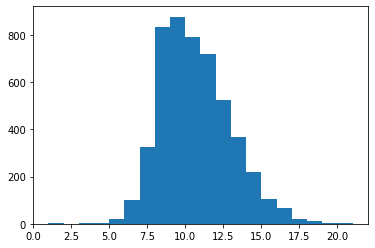

In [ ]:
word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

In [ ]:
np.quantile(word_count, 0.025)

6.0

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 20
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1968
 tweet 의 길이의 중간값 : 10.0




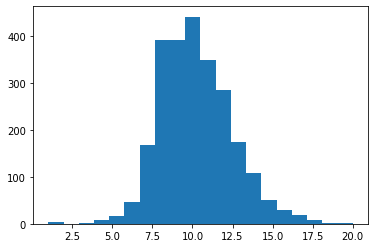

In [ ]:
word_count = test_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

## 토큰화 및 패딩

In [ ]:
train_tweet = train_df['Tweet'].values
test_tweet = test_df['Tweet'].values

In [ ]:
train_tweet[:2]

array(['joke hop plane rn well covid lol',
       'banmediahouse whose responsible spreading fake communal story pandemic covid situation'],
      dtype=object)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweet)

train_token = tokenizer.texts_to_sequences(train_tweet)
train_token[0]

[8, 1838, 2382, 357, 96, 1, 133]

In [ ]:
print(train_tweet[0])
print(train_token[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]


In [ ]:
word_vocab = tokenizer.word_index
#print(word_vocab)

In [ ]:
print(f'단어 전체의 갯수 {len(word_vocab)}')

단어 전체의 갯수 8517


In [ ]:
maxlen = 21 # 전처리 후 최댓값
train_pad = pad_sequences(train_token, maxlen = maxlen, padding = 'pre')
print(train_tweet[0])
print(train_token[0])
print(train_pad[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    8 1838 2382  357   96    1  133]


In [ ]:
print(type(train_pad))
print(train_pad.shape)
print(train_pad[0].shape)

<class 'numpy.ndarray'>
(5000, 21)
(21,)


## 벡터화


### SENTENCEPIECE

In [ ]:
!pip install sentencepiece
import sentencepiece as spm

     |████████████████████████████████| 1.2MB 12.6MB/s 


In [ ]:
train_tweet.shape

(5000,)

In [ ]:
with open('./full_tweet.txt', 'w', encoding='utf-8') as f:
    for line in train_tweet :
        if len(str(line).strip()) == 0 : continue
        try : 
            f.write(line + '\n')
        except : continue

In [ ]:
!cat full_tweet.txt | head -n2

joke hop plane rn well covid lol
banmediahouse whose responsible spreading fake communal story pandemic covid situation


In [ ]:
spm.SentencePieceTrainer.train('--input=full_tweet.txt --model_prefix=m --vocab_size=5000')

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [ ]:
train_df['bow'] = train_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))
test_df['bow'] = test_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))

In [ ]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10,bow
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[22, 369, 2018, 542, 164, 3, 222]"
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1055, 2401, 2059, 148, 458, 1402, 58, 98, 4, ..."


In [ ]:
test_df.head(2)

,ID,Tweet,bow
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ..."
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ..."


In [ ]:
train_pad = pad_sequences(train_df['bow'].values, maxlen=22)
test_pad = pad_sequences(test_df['bow'].values, maxlen=22)

In [ ]:
train_pad.shape

(5000, 22)